In [1]:
import requests
import pandas as pd
from datetime import datetime
import pandas as pd

In [6]:
rtt_first = requests.get(
    """
https://phl.carto.com/api/v2/sql?q=SELECT * FROM rtt_summary order by recording_date asc limit 1
"""
).json()["rows"][0]
rtt_last = requests.get(
    """
https://phl.carto.com/api/v2/sql?q=SELECT * FROM rtt_summary order by recording_date desc limit 1
"""
).json()["rows"][0]
print(f"Earliest Date: {rtt_first['recording_date']}")
print(f"Latest Date: {rtt_last['recording_date']}")

Earlies Date: 1999-12-06T00:00:00Z
Latest Date: 2021-01-29T00:00:00Z


In [3]:
rtt = requests.get(
    """
https://phl.carto.com/api/v2/sql?q=SELECT * FROM rtt_summary where 

address_low_frac is not null 
and address_high is not null
limit 10
"""
).json()["rows"]

In [30]:
rtt[0]

#1224R-38 N 9TH ST
#address_lowaddress_low_suffix-address_high street_predir street_name street_suffix
#address_low-address_high address_low_frac street_name street_suffix

#address_low address_low_frac street_predir street_name street_fuffix

#{address_low}{address_low_suffix}-{address_high} {address_low_frac} {street_predir} {street_name} {street_suffix}

{'cartodb_id': 52417,
 'the_geom': '0101000020E61000007ACC532BE6CA52C0385707E4AD044440',
 'the_geom_webmercator': '0101000020110F0000C59FEAD5CBEB5FC11505A90116955241',
 'objectid': 7791311,
 'document_id': 50981491,
 'document_type': 'DEED',
 'display_date': '2004-07-26T00:00:00Z',
 'street_address': '227-31 1/2 CHURCH LN',
 'zip_code': '19144',
 'ward': '12',
 'grantors': 'MCFARLAND LANDSCAPE SERVICES INC',
 'grantees': 'MCFARLAND LANDSCAPE SERVICES INC',
 'cash_consideration': 1,
 'other_consideration': None,
 'total_consideration': 1,
 'assessed_value': None,
 'common_level_ratio': None,
 'fair_market_value': 35808,
 'state_tax_amount': 0,
 'state_tax_percent': 100,
 'local_tax_amount': 0,
 'local_tax_percent': 100,
 'adjusted_cash_consideration': 1,
 'adjusted_other_consideration': None,
 'adjusted_total_consideration': 1,
 'adjusted_assessed_value': None,
 'adjusted_fair_market_value': 35808,
 'adjusted_state_tax_amount': None,
 'adjusted_local_tax_amount': None,
 'receipt_num': N

In [42]:
rtt_document_types = requests.get(
    """
https://phl.carto.com/api/v2/sql?q=SELECT document_type, count(*) FROM rtt_summary group by document_type
"""
).json()["rows"]
rtt_document_types_df = pd.DataFrame(rtt_document_types).sort_values(
    "count", ascending=False
)
rtt_document_types_df

,document_type,count
11,MORTGAGE,1257384
13,SATISFACTION,953096
5,DEED,856222
2,ASSIGNMENT OF MORTGAGE,349464
7,DEED MISCELLANEOUS,320604
12,RELEASE OF MORTGAGE,226924
10,DEED SHERIFF,81653
1,AMENDMENT TO CONDOMINIUM,24531
4,DECLARATION OF CONDOMINIUM,12072
9,DEED OF CONDEMNATION,6217


In [43]:
rtt_grantees_counts = requests.get(
    """
https://phl.carto.com/api/v2/sql?q=select * from (SELECT grantees, count(*) as num FROM rtt_summary group by grantees) sub 
order by sub.num desc limit 10
"""
).json()["rows"]
rtt_grantees_df = pd.DataFrame(rtt_grantees_counts)
rtt_grantees_df

,grantees,num
0,WACHOVIA BANK NATIONAL ASSOCIATION,41831
1,CITIZENS BANK OF PENNSYLVANIA,38462
2,PENNSYLVANIA HOUSING FINANCE AGENCY,37813
3,POLICE & FIRE FEDERAL CREDIT UNION,35023
4,SOVEREIGN BANK,34725
5,PNC BANK NATIONAL ASSOCIATION,33699
6,WELLS FARGO BANK NA,32972
7,POLICE AND FIRE FEDERAL CREDIT UNION,27359
8,WELLS FARGO BANK N A,27109
9,SECRETARY OF HOUSING AND URBAN DEVELOPMENT,25516


In [44]:
rtt_opa_account_num_counts = requests.get(
    """
https://phl.carto.com/api/v2/sql?q=select * from (SELECT opa_account_num, count(*) as num FROM rtt_summary group by opa_account_num) sub 
order by sub.num desc limit 10
"""
).json()["rows"]
rtt_df = pd.DataFrame(rtt_opa_account_num_counts)
rtt_df

,opa_account_num,num
0,None,245230
1,881006325,1073
2,883427750,769
3,881025500,695
4,772732000,647
5,881012035,408
6,182265600,333
7,881442772,306
8,881515482,305
9,881790000,301


In [45]:
matching_rtt_results = requests.get(
    """
    https://phl.carto.com/api/v2/sql?q=
    SELECT rtt.street_address, rtt.document_type, rtt.grantors, rtt.grantees, rtt.opa_account_num, rtt.total_consideration, rtt.condo_name, rtt.unit_num,
    rtt.receipt_date, rtt.recording_date, opp.location, opp.owner_1
    FROM rtt_summary rtt, opa_properties_public opp where  rtt.opa_account_num= opp.parcel_number limit 1000
"""
).json()["rows"]
matching_rtt = pd.DataFrame(matching_rtt_results)

In [46]:
matching_rtt_results = requests.get(
    """
    https://phl.carto.com/api/v2/sql?q=
    SELECT rtt.opa_account_num, 
    opp.location, 
    rtt.document_type, rtt.grantors, rtt.grantees, opp.owner_1, opp.owner_2, bl.legalname, bl.legalentitytype,
    rtt.receipt_date,  bl.initialissuedate, bl.expirationdate, bl.licensestatus, bl.numberofunits
    FROM rtt_summary rtt, opa_properties_public opp, business_licenses bl
    where  rtt.opa_account_num= opp.parcel_number and rtt.opa_account_num = bl.opa_account_num
    and rtt.document_type like '%DEED%' 
    and bl.initialissuedate > rtt.receipt_date 
    and bl.licensetype = 'Rental'
    order by location, receipt_date, initialissuedate
    limit 100
"""
).json()["rows"]
matching_rtt = pd.DataFrame(matching_rtt_results)
matching_rtt

,opa_account_num,location,document_type,grantors,grantees,owner_1,owner_2,legalname,legalentitytype,receipt_date,initialissuedate,expirationdate,licensestatus,numberofunits
0,881428110,1000-02 S 52ND ST,DEED,MAYGER MAGDY R,AYOUB NABIL RAMSIS,RAZA HOMES LLC,None,RAZA HOMES LLC,Company,2007-09-06T00:00:00Z,2015-10-30T10:07:00Z,2021-10-31T00:00:00Z,Active,6
1,881428110,1000-02 S 52ND ST,DEED,AYOUB NABIL RAMSIS,MAYGER ISABELLE BASIT; MAYGER MAGDY R,RAZA HOMES LLC,None,RAZA HOMES LLC,Company,2009-03-27T00:00:00Z,2015-10-30T10:07:00Z,2021-10-31T00:00:00Z,Active,6
2,881428110,1000-02 S 52ND ST,DEED,MAYGER ISABELLE BASIT; MAYGER MAGDY R,RAZA HOMES LLC,RAZA HOMES LLC,None,RAZA HOMES LLC,Company,2015-10-07T00:00:00Z,2015-10-30T10:07:00Z,2021-10-31T00:00:00Z,Active,6
3,582435800,10000 JEANES ST,DEED,PELLEGRINO FRANK; PELLEGRINO MARY,AYBINDER DMITRY,AYBINDER DMITRY,None,AYBINDER DMITRY,Individual,2003-08-11T00:00:00Z,2004-05-05T00:00:00Z,2022-02-28T00:00:00Z,Active,2
4,881515515,1000-12 SOUTH ST,DEED,RIBA IN,MILAN ENTERPRISES L P,MILAN ENTERPRISES L P,None,MILLAN ENTERPRISES LP,Company,2003-02-14T00:00:00Z,2004-04-08T00:00:00Z,2022-02-28T00:00:00Z,Active,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,771205000,1001-07 S 4TH ST,DEED MISCELLANEOUS,STEEPLE LOFTS LLC,FIRSTRUST BANK,STEEPLE LOFTS LLC,None,KOPEL ELLIOT,Individual,2019-07-11T00:00:00Z,2020-12-08T14:43:58Z,2021-12-07T14:43:58Z,Active,40
96,771205000,1001-07 S 4TH ST,DEED MISCELLANEOUS,STEEPLE LOFTS LLC,CITY OF PHILADELPHIA,STEEPLE LOFTS LLC,None,KOPEL ELLIOT,Individual,2019-08-16T00:00:00Z,2020-12-08T14:43:58Z,2021-12-07T14:43:58Z,Active,40
97,582465300,10010 BRIDLE RD,DEED,ORTIZ ANGEL,MARTINEZ JOCELYN A,BABIN MAXIM,None,BABIN MAX,Individual,2002-01-10T00:00:00Z,2014-05-13T09:18:10Z,2022-02-28T00:00:00Z,Active,2
98,582465300,10010 BRIDLE RD,DEED,MARTINEZ JOCELYN A,CHANIN MIRA; ZIMOUETS ALEKSANDR,BABIN MAXIM,None,BABIN MAX,Individual,2003-11-03T00:00:00Z,2014-05-13T09:18:10Z,2022-02-28T00:00:00Z,Active,2


In [47]:
n_deeds_w_rental_licenses = requests.get(
    """
    https://phl.carto.com/api/v2/sql?q=
    SELECT count(distinct(rtt.opa_account_num))
    FROM rtt_summary rtt, opa_properties_public opp, business_licenses bl
    where  rtt.opa_account_num= opp.parcel_number and rtt.opa_account_num = bl.opa_account_num
    and rtt.document_type like '%DEED%' 
    and bl.initialissuedate > rtt.receipt_date 
    and bl.licensetype = 'Rental'
"""
).json()["rows"][0]["count"]
print(f"There were {n_deeds_w_rental_licenses} deeds with rental licenses found")

There were 123080 deeds with rental licenses found


In [48]:
# Attempts to find houses with many sales
rtt_results = requests.get(
    """
    https://phl.carto.com/api/v2/sql?q=
    select * from (
    SELECT opa_account_num, (max(receipt_date) - min(receipt_date)) as min_diff_days, 
    count(receipt_date) as num_sales,
    max(receipt_date) as max_receipt_date, min(receipt_date) as min_reciept_date
    FROM rtt_summary rtt where rtt.document_type like '%DEED%' 
    and opa_account_num is not null and receipt_date is not null
    group by opa_account_num order by min_diff_days 
    ) rtt2 where num_sales > 1
"""
).json()
pd.DataFrame(rtt_results["rows"])

,opa_account_num,min_diff_days,num_sales,max_receipt_date,min_reciept_date
0,561005200,0,2,2001-02-02T00:00:00Z,2001-02-02T00:00:00Z
1,651213200,0,2,2007-10-11T00:00:00Z,2007-10-11T00:00:00Z
2,874508240,0,2,2002-03-06T00:00:00Z,2002-03-06T00:00:00Z
3,411279300,0,2,2019-09-23T00:00:00Z,2019-09-23T00:00:00Z
4,583163207,0,2,2000-05-23T00:00:00Z,2000-05-23T00:00:00Z
...,...,...,...,...,...
245690,161152600,7682,6,2020-12-31T00:00:00Z,1999-12-20T00:00:00Z
245691,051179600,7684,5,2020-12-23T00:00:00Z,1999-12-10T00:00:00Z
245692,883427750,7685,117,2020-12-24T00:00:00Z,1999-12-10T00:00:00Z
245693,323100810,7688,2,2020-12-30T00:00:00Z,1999-12-13T00:00:00Z


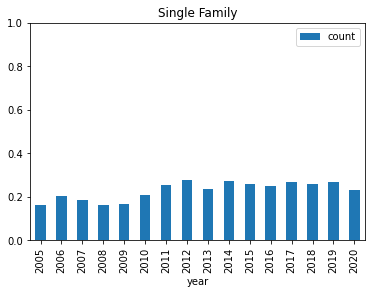

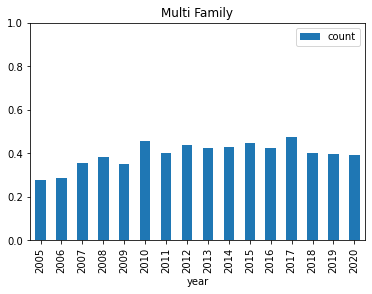

In [76]:
# Attempts to find houses purchased by LLCs

llc_names = [
    " LLC", " LP", ",LP", "AGENCY", "PARTNER", "ASSOC", 
    "LIMITED", " LTD", "DEVELOPMENT", " INC", "CORP","GROUP","INVEST", "REALTY", "PRTNR", " HOUSING", 
    "RESIDENTIAL", " L P", " L L C", "PROPERT", "ENTERPRISE", " L.L.C.", "L.P.", " L,C"
]

def _sql_is_llc(column, llc_names):
    return " or ".join([f"{column} like '%{llc_name}%'" for llc_name in llc_names])


for category_code_description in ['Single Family', 'Multi Family']:
    rtt_results = requests.get(
        f"""
        https://phl.carto.com/api/v2/sql?q=
        select extract(year from rtt.recording_date) as year, count(*) 
        FROM rtt_summary rtt, opa_properties_public opa
        where rtt.opa_account_num = opa.parcel_number
        AND rtt.document_type like '%DEED%' 
        AND (
            ({_sql_is_llc('grantees',llc_names)}) 
        )
        AND opa.category_code_description = '{category_code_description}'
        GROUP BY extract(year from rtt.recording_date)
    """
    ).json()
    df_llc = pd.DataFrame(rtt_results["rows"]).set_index('year')

    rtt_results = requests.get(
        f"""
        https://phl.carto.com/api/v2/sql?q=
        select extract(year from rtt.recording_date) as year, count(*) 
        FROM rtt_summary rtt, opa_properties_public opa
        where rtt.opa_account_num = opa.parcel_number
        AND rtt.document_type like '%DEED%' 
        AND opa.category_code_description = '{category_code_description}'
        GROUP BY extract(year from rtt.recording_date)
    """
    ).json()
    df_all = pd.DataFrame(rtt_results["rows"]).set_index('year')

    pct_diff = (df_llc/df_all).loc[2005:]
    plot = pct_diff.plot.bar()
    fig = plot.get_figure()
    plot.set_title(category_code_description)
    plot.set_ylim([0,1])
    fig.savefig(f'deeds_{category_code_description}.jpg')